In [2]:
# importing required packages

import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import re, collections

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso


from sklearn.model_selection import GridSearchCV
from sklearn.metrics import cohen_kappa_score

In [2]:
# getting data in a pandas dataframe

import pandas as pd
X = pd.read_excel('training_set_rel3.xls')
y = X['domain1_score']
X = X.dropna(axis=1)
X = X.drop(columns=['rater1_domain1', 'rater2_domain1'])
dataframe = X
X.head()


,essay_id,essay_set,essay,domain1_score
0,1,1,"Dear local newspaper, I think effects computer...",8
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",9
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",7
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",10
4,5,1,"Dear @LOCATION1, I know having computers has a...",8


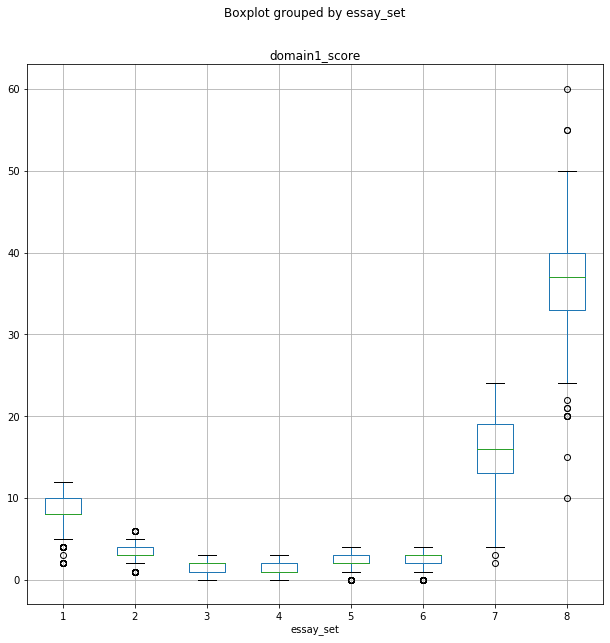

In [3]:
# Boxlot can be used to visualize the distribution of domain1_score values over each essay set.

%matplotlib inline
dataframe.boxplot(column = 'domain1_score', by = 'essay_set', figsize = (10, 10))

In [4]:
# getting relevant columns

data = dataframe[['essay_set','essay','domain1_score']].copy()

data

,essay_set,essay,domain1_score
0,1,"Dear local newspaper, I think effects computer...",8
1,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",9
2,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",7
3,1,"Dear Local Newspaper, @CAPS1 I have found that...",10
4,1,"Dear @LOCATION1, I know having computers has a...",8
...,...,...,...
12973,8,In most stories mothers and daughters are eit...,35
12974,8,I never understood the meaning laughter is th...,32
12975,8,"When you laugh, is @CAPS5 out of habit, or is ...",40
12976,8,Trippin' on fen...,40


In [5]:
# Tokenize a sentence into words

def sentence_to_wordlist(raw_sentence):
    
    clean_sentence = re.sub("[^a-zA-Z0-9]"," ", raw_sentence)
    tokens = nltk.word_tokenize(clean_sentence)
    
    return tokens

In [7]:
# tokenizing an essay into a list of word lists

def tokenize(essay):
    stripped_essay = essay.strip()
    
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    raw_sentences = tokenizer.tokenize(stripped_essay)
    
    tokenized_sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            tokenized_sentences.append(sentence_to_wordlist(raw_sentence))
    
    return tokenized_sentences

In [9]:
# calculating number of words in an essay

def word_count(essay):
    
    clean_essay = re.sub(r'\W', ' ', essay)
    words = nltk.word_tokenize(clean_essay)
    
    return len(words)

In [10]:
# calculating number of characters in an essay

def char_count(essay):
    
    clean_essay = re.sub(r'\s', '', str(essay).lower())
    
    return len(clean_essay)

In [11]:
# calculating number of sentences in an essay

def sent_count(essay):
    
    sentences = nltk.sent_tokenize(essay)
    
    return len(sentences)

In [12]:
# calculating number of lemmas per essay

def count_lemmas(essay):
    
    tokenized_sentences = tokenize(essay)      
    
    lemmas = []
    wordnet_lemmatizer = WordNetLemmatizer()
    
    for sentence in tokenized_sentences:
        tagged_tokens = nltk.pos_tag(sentence) 
        
        for token_tuple in tagged_tokens:
        
            pos_tag = token_tuple[1]
        
            if pos_tag.startswith('N'): 
                pos = wordnet.NOUN
                lemmas.append(wordnet_lemmatizer.lemmatize(token_tuple[0], pos))
            elif pos_tag.startswith('J'):
                pos = wordnet.ADJ
                lemmas.append(wordnet_lemmatizer.lemmatize(token_tuple[0], pos))
            elif pos_tag.startswith('V'):
                pos = wordnet.VERB
                lemmas.append(wordnet_lemmatizer.lemmatize(token_tuple[0], pos))
            elif pos_tag.startswith('R'):
                pos = wordnet.ADV
                lemmas.append(wordnet_lemmatizer.lemmatize(token_tuple[0], pos))
            else:
                pos = wordnet.NOUN
                lemmas.append(wordnet_lemmatizer.lemmatize(token_tuple[0], pos))
    
    lemma_count = len(set(lemmas))
    
    return lemma_count

In [13]:
word_count(dataframe.iloc[0]['essay'])

350

In [14]:
l= count_lemmas(dataframe.iloc[0]['essay'])
l

162

In [15]:
data[data['essay_set'] == 1]['essay']

0       Dear local newspaper, I think effects computer...
1       Dear @CAPS1 @CAPS2, I believe that using compu...
2       Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...
3       Dear Local Newspaper, @CAPS1 I have found that...
4       Dear @LOCATION1, I know having computers has a...
                              ...                        
1778    Dear @CAPS1, @CAPS2 several reasons on way I t...
1779    Do a adults and kids spend to much time on the...
1780    My opinion is that people should have computer...
1781    Dear readers, I think that its good and bad to...
1782    Dear - Local Newspaper I agree thats computers...
Name: essay, Length: 1783, dtype: object

In [16]:
# calculating number of nouns, adjectives, verbs and adverbs in an essay

def count_pos(essay):
    
    tokenized_sentences = tokenize(essay)
    #print(tokenized_sentences)
    noun_count = 0
    adj_count = 0
    verb_count = 0
    adv_count = 0
    
    for sentence in tokenized_sentences:
        tagged_tokens = nltk.pos_tag(sentence)
        
        for token_tuple in tagged_tokens:
            pos_tag = token_tuple[1]
        
            if pos_tag.startswith('N'): 
                noun_count += 1
            elif pos_tag.startswith('J'):
                adj_count += 1
            elif pos_tag.startswith('V'):
                verb_count += 1
            elif pos_tag.startswith('R'):
                adv_count += 1
            
    return noun_count, adj_count, verb_count, adv_count
    

In [1]:
n,a,v,ad= count_pos(dataframe.iloc[0]['essay'])


In [26]:
data[data['essay_set']==1]

,essay_set,essay,domain1_score
0,1,"Dear local newspaper, I think effects computer...",8
1,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",9
2,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",7
3,1,"Dear Local Newspaper, @CAPS1 I have found that...",10
4,1,"Dear @LOCATION1, I know having computers has a...",8
...,...,...,...
1778,1,"Dear @CAPS1, @CAPS2 several reasons on way I t...",8
1779,1,Do a adults and kids spend to much time on the...,7
1780,1,My opinion is that people should have computer...,8
1781,1,"Dear readers, I think that its good and bad to...",2


In [20]:
# getiing Bag of Words (BOW) counts

def get_count_vectors(essays):
    
    vectorizer = CountVectorizer(max_features = 10000, ngram_range=(1, 3), stop_words='english')
    
    count_vectors = vectorizer.fit_transform(essays)
    
    feature_names = vectorizer.get_feature_names()
    
    return feature_names, count_vectors

In [ ]:
# splitting data into train data and test data (70/30)

feature_names_cv, count_vectors = get_count_vectors(data[data['essay_set'] == 1]['essay'])

X_cv = count_vectors.toarray()

y_cv = data[data['essay_set'] == 1]['domain1_score'].as_matrix()

X_train, X_test, y_train, y_test = train_test_split(X_cv, y_cv, test_size = 0.3)

In [27]:
# Training a Linear Regression model using only Bag of Words (BOW)

linear_regressor = LinearRegression()

linear_regressor.fit(X_train, y_train)

y_pred = linear_regressor.predict(X_test)

# The coefficients
print('Coefficients: \n', linear_regressor.coef_)


print('Cohen\'s kappa score: %.2f' % cohen_kappa_score(np.rint(y_pred), y_test))


Coefficients: 
 [ 0.02996525  0.08560296 -0.05500048 ... -0.02886838  0.03101865
  0.02488245]
Cohen's kappa score: 0.18


In [28]:
# extracting essay features

def extract_features(data):
    
    features = data.copy()
    
    features['char_count'] = features['essay'].apply(char_count)
    
    features['word_count'] = features['essay'].apply(word_count)
    
    features['sent_count'] = features['essay'].apply(sent_count)
    
    features['avg_word_len'] = features['essay'].apply(avg_word_len)
    
    features['lemma_count'] = features['essay'].apply(count_lemmas)
        
    features['noun_count'], features['adj_count'], features['verb_count'], features['adv_count'] = zip(*features['essay'].map(count_pos))
    
    return features

In [29]:
# extracting features from essay set 1

features_set1 = extract_features(data[data['essay_set'] == 1])

features_set1

,essay_set,essay,domain1_score,char_count,word_count,sent_count,avg_word_len,lemma_count,noun_count,adj_count,verb_count,adv_count
0,1,"Dear local newspaper, I think effects computer...",8,1538,350,16,4.237143,162,83,18,74,24
1,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",9,1870,423,20,4.312057,185,107,19,85,19
2,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",7,1263,283,14,4.342756,145,82,20,52,16
3,1,"Dear Local Newspaper, @CAPS1 I have found that...",10,2642,530,27,4.813208,236,178,42,97,29
4,1,"Dear @LOCATION1, I know having computers has a...",8,2105,473,30,4.334038,190,114,32,90,36
...,...,...,...,...,...,...,...,...,...,...,...,...
1778,1,"Dear @CAPS1, @CAPS2 several reasons on way I t...",8,2094,509,21,4.015717,206,114,35,108,39
1779,1,Do a adults and kids spend to much time on the...,7,892,214,18,4.004673,109,53,13,46,10
1780,1,My opinion is that people should have computer...,8,1352,296,18,4.489865,100,82,15,56,8
1781,1,"Dear readers, I think that its good and bad to...",2,57,15,1,3.733333,14,2,3,2,0


In [32]:
X.shape

(12978, 4)

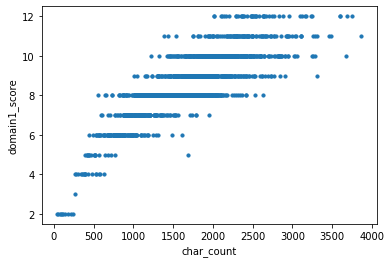

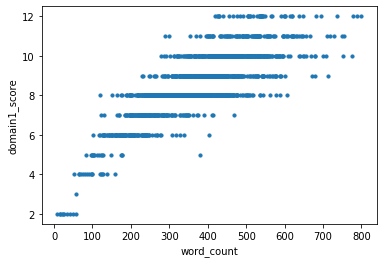

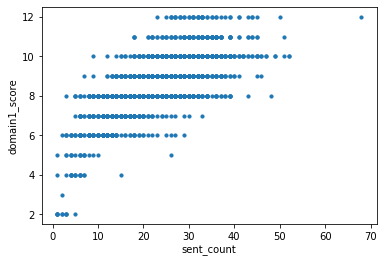

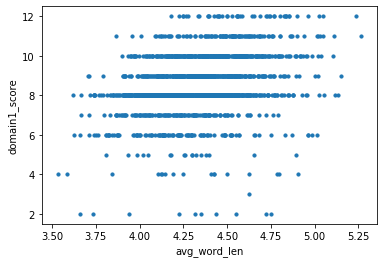

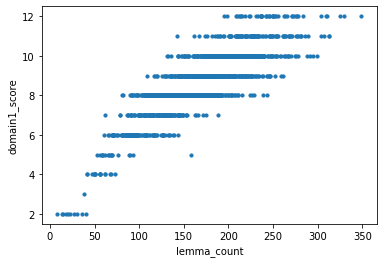

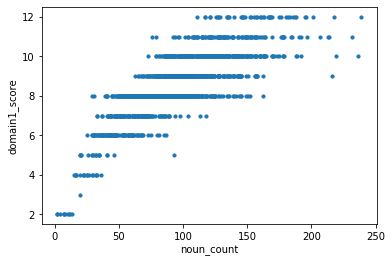

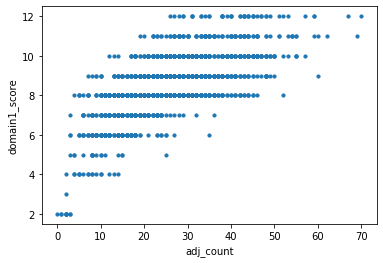

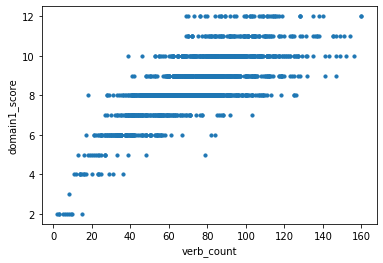

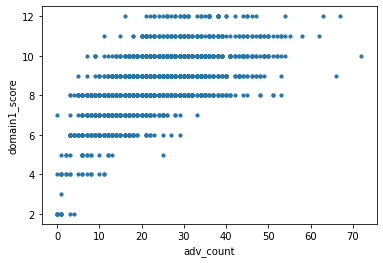

In [30]:
# Exploratory Data Analysis (EDA) on the data

%matplotlib inline
features_set1.plot.scatter(x = 'char_count', y = 'domain1_score', s=10)
features_set1.plot.scatter(x = 'word_count', y = 'domain1_score', s=10)
features_set1.plot.scatter(x = 'sent_count', y = 'domain1_score', s=10)
features_set1.plot.scatter(x = 'avg_word_len', y = 'domain1_score', s=10)
features_set1.plot.scatter(x = 'lemma_count', y = 'domain1_score', s=10)
features_set1.plot.scatter(x = 'noun_count', y = 'domain1_score', s=10)
features_set1.plot.scatter(x = 'adj_count', y = 'domain1_score', s=10)
features_set1.plot.scatter(x = 'verb_count', y = 'domain1_score', s=10)
features_set1.plot.scatter(x = 'adv_count', y = 'domain1_score', s=10)



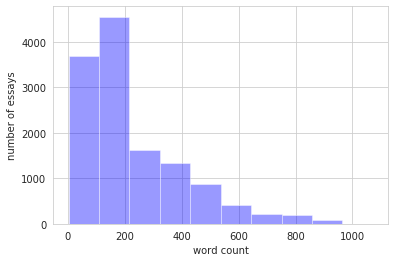

In [33]:
import seaborn as sns
sns.set_style('whitegrid') 
fig = sns.distplot(wordcount, kde = False, bins = 10,color = 'blue')



plt.xlabel('word count')
plt.ylabel('number of essays')
#lines = [6,5,4,3,2,1]
#labels = ['A+:6', 'A', 'B+','B','C','D']
#plt.legend(lines, labels)
#plt.legend(labels)
plt.show(fig)


In [34]:
sentcount = []
for i in range(X.shape[0]):
    sentcount.append(sent_count(X.iloc[i]['essay']))
#word_count(X['essay'])
len(sentcount)

12978

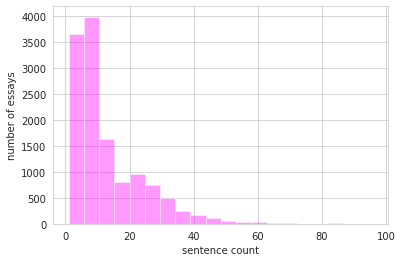

In [131]:
import seaborn as sns
sns.set_style('whitegrid') 
fig = sns.distplot(sentcount, kde = False, bins = 20,color = 'magenta')



plt.xlabel('sentence count')
plt.ylabel('number of essays')
#lines = [6,5,4,3,2,1]
#labels = ['A+:6', 'A', 'B+','B','C','D']
#plt.legend(lines, labels)
#plt.legend(labels)
plt.show(fig)

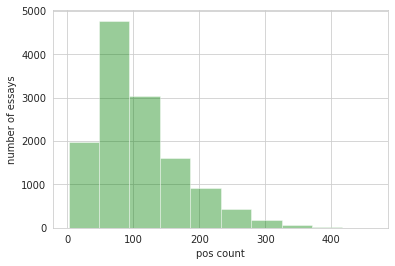

In [129]:
import seaborn as sns
sns.set_style('whitegrid') 
fig = sns.distplot(poscount, kde = False, bins = 10,color = 'green')



plt.xlabel('pos count')
plt.ylabel('number of essays')
#lines = [6,5,4,3,2,1]
#labels = ['A+:6', 'A', 'B+','B','C','D']
#plt.legend(lines, labels)
#plt.legend(labels)
plt.show(fig)

In [42]:
features_dict={}
for i in range(1,9):
        print(i)
        features_dict["features_set{0}".format(i)] = extract_features(data[data['essay_set'] == i])

1
2
3
4
5
6
7
8


In [43]:
features_set2 = features_dict['features_set2']
features_set2

,essay_set,essay,domain1_score,char_count,word_count,sent_count,avg_word_len,lemma_count,noun_count,adj_count,verb_count,adv_count
1783,2,Certain materials being removed from libraries...,4,2143,486,19,4.279835,187,127,34,95,32
1784,2,Write a persuasive essay to a newspaper reflec...,1,666,170,3,3.841176,80,38,15,46,6
1785,2,Do you think that libraries should remove cert...,2,930,227,15,3.898678,116,57,17,45,15
1786,2,"In @DATE1's world, there are many things found...",4,2179,470,31,4.512766,168,99,28,122,30
1787,2,In life you have the 'offensive things'. The l...,4,1902,431,35,4.236659,205,109,29,93,30
...,...,...,...,...,...,...,...,...,...,...,...,...
3578,2,The author is writting about taking books off ...,3,1054,271,12,3.726937,101,65,19,66,15
3579,2,"I do not think that materials, such as books, ...",3,1092,248,16,4.254032,120,65,22,48,17
3580,2,"Yes we should keep the books,music,movies,an m...",2,475,118,5,3.923729,64,30,3,22,5
3581,2,"I do believe that book, magazines, music, mov...",3,2188,510,23,4.174510,156,125,26,121,31


In [45]:
features_set2.iloc[:, 3:]
#features_dict

,char_count,word_count,sent_count,avg_word_len,lemma_count,noun_count,adj_count,verb_count,adv_count
1783,2143,486,19,4.279835,187,127,34,95,32
1784,666,170,3,3.841176,80,38,15,46,6
1785,930,227,15,3.898678,116,57,17,45,15
1786,2179,470,31,4.512766,168,99,28,122,30
1787,1902,431,35,4.236659,205,109,29,93,30
...,...,...,...,...,...,...,...,...,...
3578,1054,271,12,3.726937,101,65,19,66,15
3579,1092,248,16,4.254032,120,65,22,48,17
3580,475,118,5,3.923729,64,30,3,22,5
3581,2188,510,23,4.174510,156,125,26,121,31


In [46]:
features_dict['features_set2']['domain1_score']

1783    4
1784    1
1785    2
1786    4
1787    4
       ..
3578    3
3579    3
3580    2
3581    3
3582    3
Name: domain1_score, Length: 1800, dtype: int64

In [151]:
feature_names_cv, count_vectors = get_count_vectors(data[data['essay_set'] == 6]['essay'])

X_cv = count_vectors.toarray()

#y_cv = data[data['essay_set'] == 2]['domain1_score'].as_matrix()

#X_train, X_test, y_train, y_test = train_test_split(X_cv, y_cv, test_size = 0.3)

In [152]:
features_set6 = features_dict['features_set6']

X = np.concatenate((features_set6.iloc[:, 3:].values, X_cv), axis = 1)

y = features_dict['features_set6']['domain1_score'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [153]:
# Training a Linear Regresssion using all the features (BOW + other features)

curr_set = 6
linear_regressor = LinearRegression()

linear_regressor.fit(X_train, y_train)

y_pred = linear_regressor.predict(X_test)

# The coefficients
print('Coefficients: \n', linear_regressor.coef_)



# Cohen’s kappa score: 1 is complete agreement
print('Cohen\'s kappa score of set{0}: %.2f'.format(curr_set) % cohen_kappa_score(np.rint(y_pred), y_test))


Coefficients: 
 [-0.00205585  0.00065022 -0.00139438 ...  0.00541578  0.01759518
  0.0060183 ]
Cohen's kappa score of set6: 0.40


In [156]:
# Training a Lasso Regression model (l1 regularization) using all the features (BOW + other features)

alphas = np.array([3, 1, 0.3, 0.1])

lasso_regressor = Lasso()

grid = GridSearchCV(estimator = lasso_regressor, param_grid = dict(alpha=alphas))
grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)


# kappa score: 1 is complete agreement
print('Cohen\'s kappa score of set{0}: %.2f'.format(curr_set)% cohen_kappa_score(np.rint(y_pred), y_test))


/home/adarsh/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Cohen's kappa score of set6:  0.62


In [148]:
import math
l = [i for i in range(1,9)]
df = data
c = 0
for i in l:
    m = -1
    count = -1
    for j in range(c,df.shape[0]):
        if(df['essay_set'][j]==i):
            count+=1
            if(df['domain1_score'][j]>m): 
                m = df['domain1_score'][j]
        else:break
    print("essay set ", i , "max score: ",m)
    c+=count+1

essay set  1 max score:  12
essay set  2 max score:  6
essay set  3 max score:  3
essay set  4 max score:  3
essay set  5 max score:  4
essay set  6 max score:  4
essay set  7 max score:  24
essay set  8 max score:  60


In [149]:
import math
l = [i for i in range(1,9)]

c = 0
df = data
for i in l:
    m = 1000
    count = -1
    for j in range(c,df.shape[0]):
        if(df['essay_set'][j]==i):
            count+=1
            if(df['domain1_score'][j]<m): 
                m = df['domain1_score'][j]
        else:break
    print("essay set ", i , "min score: ",m)
    c+=count+1

essay set  1 min score:  2
essay set  2 min score:  1
essay set  3 min score:  0
essay set  4 min score:  0
essay set  5 min score:  0
essay set  6 min score:  0
essay set  7 min score:  2
essay set  8 min score:  10


In [118]:
#the list below is the kappa values obtained by using Lasso regression on each of the 8 essay set.

lasso_list = [0.46, 0.56, 0.68,0.67,0.61,0.62,0.39,0.34]
ans = 0
for i in lasso_list:
    ans+=i
print(ans)
print(ans/8)

4.33
0.54125


Text(0.5, 1.0, 'Linear Regression kappa Score')

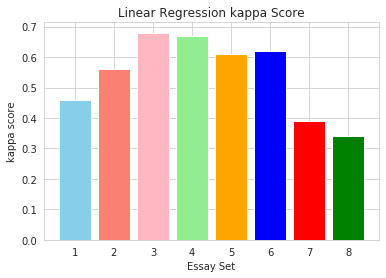

In [145]:
import numpy as np
import matplotlib.pyplot as plt

lr_list = [0.46, 0.56, 0.68,0.67,0.61,0.62,0.39,0.34]

bars=[1,2,3,4,5,6,7,8]
y=np.arange(len(bars))

plt.bar(y,lr_list,color=['skyblue','salmon','lightpink','lightgreen','orange','blue','red','green'])
plt.xticks(y,bars)
plt.xlabel('Essay Set')
plt.ylabel('kappa score')
plt.title('Linear Regression(Lasso) kappa Score')

In [ ]:
#Features given to the linear(lasso) regression model are
#1.word count
#2.sentence count
#3.avg sentence length
#4.pos count
#5.Bag of Words

#Lasso regression was also applied
#lasso was applied bcoz it performes better than regular linear regression model
#lasso uses L1 regularization.
#Lasso regression and ridge regession are some of the simple techniques to reduce model complexity
#and prevent over-fitting which may result from simple linear regression.

In [150]:
features_dict['features_set6']

,essay_set,essay,domain1_score,char_count,word_count,sent_count,avg_word_len,lemma_count,noun_count,adj_count,verb_count,adv_count
8886,6,There were many obstacles that the builders fa...,2,573,123,6,4.560976,85,35,11,19,8
8887,6,"Him from the start, there would have been many...",3,873,180,9,4.733333,106,51,14,30,12
8888,6,The builders of the Empire State Building face...,4,773,169,8,4.491124,97,51,11,29,12
8889,6,In the passage The Mooring Mast by Marcia Amid...,1,906,199,7,4.417085,112,70,6,35,4
8890,6,The builders of the Empire State Building face...,3,768,162,10,4.654321,87,43,20,30,6
...,...,...,...,...,...,...,...,...,...,...,...,...
10681,6,The one obstacle the builders had when trying ...,0,708,154,8,4.474026,82,42,7,29,15
10682,6,Some of the problems with the constructing of ...,2,325,66,3,4.833333,50,17,7,14,4
10683,6,The builders of the Empire State building face...,3,503,105,5,4.657143,68,31,8,18,6
10684,6,The obstacles the builders of the Empire State...,2,308,68,2,4.485294,52,19,3,13,6


# LSTM

In [ ]:
#LSTM

#average kappa score for LSTM model obtained is 0.82.
#5 fold cross validation is used to train LSTM model.

In [106]:
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
from gensim.models import Word2vec

#global wl=0

def essay_to_wordlist(essay_v, remove_stopwords):
    """Remove the tagged labels and word tokenize the sentence."""
    essay_v = re.sub("[^a-zA-Z]", " ", essay_v)
    words = essay_v.lower().split()
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
        
    return (words)

def essay_to_sentences(essay_v, remove_stopwords):
    count = 0
    """Sentence tokenize the essay and call essay_to_wordlist() for word tokenization."""
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    raw_sentences = tokenizer.tokenize(essay_v.strip())
    #print('******')
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            #print(raw_sentence)
            w = essay_to_wordlist(raw_sentence, remove_stopwords)
            
            sentences.append(w)
            count+=1
            #print(len(raw_sentence))

    return (sentences)

def makeFeatureVec(words, model, num_features):
    """Make Feature Vector from the words list of an Essay."""
    featureVec = np.zeros((num_features,),dtype="float32")
    num_words = 0.
    index2word_set = set(model.wv.index2word)
    for word in words:
        if word in index2word_set:
            num_words += 1
            featureVec = np.add(featureVec,model[word])        
    featureVec = np.divide(featureVec,num_words)
    return featureVec

def getAvgFeatureVecs(essays, model, num_features):
    """Main function to generate the word vectors for word2vec model."""
    counter = 0
    essayFeatureVecs = np.zeros((len(essays),num_features),dtype="float32")
    for essay in essays:
        essayFeatureVecs[counter] = makeFeatureVec(essay, model, num_features)
        counter = counter + 1
    return essayFeatureVecs

In [108]:
X = dataframe
y = X['domain1_score']

In [105]:
from keras.layers import Embedding, LSTM, Dense, Dropout, Lambda, Flatten
from keras.models import Sequential, Load_model, model_from_config
import keras.backend as K

def get_model():
    """Define the model."""
    model = Sequential()
    model.add(LSTM(300, dropout=0.4, recurrent_dropout=0.4, input_shape=[1, 300], return_sequences=True))
    model.add(LSTM(64, recurrent_dropout=0.4))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='relu'))

    model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mae'])
    model.summary()

    return model
lstm_model = get_model()
print(lstm_model)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 1, 300)            721200    
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                93440     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 814,705
Trainable params: 814,705
Non-trainable params: 0
_________________________________________________________________


In [109]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import cohen_kappa_score

cv = KFold(n_splits=5, shuffle=True, random_state=len(X))
#print(cv)
results = []
y_pred_list = []
count = 1
for traincv, testcv in cv.split(X):
    print("\n--------Fold {}--------\n".format(count))
    X_test, X_train, y_test, y_train = X.iloc[testcv], X.iloc[traincv], y.iloc[testcv], y.iloc[traincv]
    print('y_train')
    print(y_train.shape)
    train_essays = X_train['essay']
    test_essays = X_test['essay']
    
    sentences = []
    
    for essay in train_essays:
            # Obtaining all sentences from the training essays.
            sentences += essay_to_sentences(essay, remove_stopwords = True)

    
    #print("sentences1 is ", sentences1)  
    #print('*'*100)
    # Initializing variables for word2vec model.
    num_features = 300 
    min_word_count = 40
    num_workers = 4
    context = 10
    downsampling = 1e-3

    print("Training Word2Vec Model...")
    model = Word2Vec(sentences, workers=num_workers, size=num_features, min_count = min_word_count, window = context, sample = downsampling)

    model.init_sims(replace=True)
    model.wv.save_word2vec_format('word2vecmodel.bin', binary=True)

    clean_train_essays = []
    
    # Generate training and testing data word vectors.
    for essay_v in train_essays:
        clean_train_essays.append(essay_to_wordlist(essay_v, remove_stopwords=True))
    trainDataVecs = getAvgFeatureVecs(clean_train_essays, model, num_features)
    
 
    
    clean_test_essays = []
    for essay_v in test_essays:
        #print('*'*100)
        clean_test_essays.append(essay_to_wordlist( essay_v, remove_stopwords=True ))
    testDataVecs = getAvgFeatureVecs( clean_test_essays, model, num_features )
    
   
    trainDataVecs = np.array(trainDataVecs)
    testDataVecs = np.array(testDataVecs)
    
  
    # Reshaping train and test vectors to 3 dimensions. (1 represnts one timestep)
    trainDataVecs = np.reshape(trainDataVecs, (trainDataVecs.shape[0], 1, trainDataVecs.shape[1]))
    testDataVecs = np.reshape(testDataVecs, (testDataVecs.shape[0], 1, testDataVecs.shape[1]))
    #x1 = testDataVecs.shape
    #y1 = trainDataVecs.shape
    #print("x1 is {} and y1 is {}".format(x1,y1))
 
    print('trainDataVecs')
    print(trainDataVecs.shape)
    print('y_train')
    print(y_train.shape)
    lstm_model = get_model()
    lstm_model.fit(trainDataVecs, y_train, batch_size=64, epochs=50)
   
    y_pred = lstm_model.predict(testDataVecs)
    
    if count == 5:
        print(" done 5 folds !!!! ")
            
    # Round y_pred to the nearest integer.
    y_pred = np.around(y_pred)
    
   
    
    # Evaluate the model on the evaluation metric. "Quadratic mean averaged Kappa"
    result = cohen_kappa_score(y_test.values,y_pred,weights='quadratic')
    
    print("Kappa Score: {}".format(result))
    
    results.append(result)

    count += 1


--------Fold 1--------

y_train
(10382,)
Training Word2Vec Model...


/home/adarsh/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/adarsh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


trainDataVecs
(10382, 1, 300)
y_train
(10382,)
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 1, 300)            721200    
_________________________________________________________________
lstm_6 (LSTM)                (None, 64)                93440     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 814,705
Trainable params: 814,705
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
10382/10382 [==============================] - 4s 374us/step - loss: 64.7716 - mae: 4.3484
Epoch 2/50
10382/10382 [==============================] - 2s 184us/step - loss: 41.2557 - mae: 3.

/home/adarsh/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/adarsh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


trainDataVecs
(10382, 1, 300)
y_train
(10382,)
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 1, 300)            721200    
_________________________________________________________________
lstm_8 (LSTM)                (None, 64)                93440     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 814,705
Trainable params: 814,705
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
10382/10382 [==============================] - 3s 260us/step - loss: 64.9404 - mae: 4.3758
Epoch 2/50
10382/10382 [==============================] - 2s 200us/step - loss: 41.9592 - mae: 3.

/home/adarsh/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/adarsh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


trainDataVecs
(10382, 1, 300)
y_train
(10382,)
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 1, 300)            721200    
_________________________________________________________________
lstm_10 (LSTM)               (None, 64)                93440     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 814,705
Trainable params: 814,705
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
10382/10382 [==============================] - 3s 250us/step - loss: 66.5338 - mae: 4.4492
Epoch 2/50
10382/10382 [==============================] - 2s 166us/step - loss: 41.6159 - mae: 3.

/home/adarsh/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/adarsh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


trainDataVecs
(10383, 1, 300)
y_train
(10383,)
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 1, 300)            721200    
_________________________________________________________________
lstm_12 (LSTM)               (None, 64)                93440     
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 814,705
Trainable params: 814,705
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
10383/10383 [==============================] - 2s 237us/step - loss: 64.2168 - mae: 4.3268
Epoch 2/50
10383/10383 [==============================] - 2s 166us/step - loss: 40.4996 - mae: 3.

/home/adarsh/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/adarsh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


trainDataVecs
(10383, 1, 300)
y_train
(10383,)
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 1, 300)            721200    
_________________________________________________________________
lstm_14 (LSTM)               (None, 64)                93440     
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 814,705
Trainable params: 814,705
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
10383/10383 [==============================] - 2s 237us/step - loss: 63.8005 - mae: 4.4188
Epoch 2/50
10383/10383 [==============================] - 2s 156us/step - loss: 41.6215 - mae: 3.